# Monetary Policy - Equities

## Imports

In [55]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pmp_functions_v5 as pmp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = "../../Data_Ryan"

## Global Variables

In [56]:
frequency = 1
t_cost = 0
target_vol = 0.1
min_regions = 4
lag = 1

## Data Setup & Cleaning

### Riskfree Data

In [57]:
# --- Load Riskfree Rate ---
factors_data = pd.read_excel(
    f"{path}/Factors.xlsx",
    index_col = 0,
    parse_dates = True
)

factors_data.index = pd.to_datetime(factors_data.index, format='%Y%m')
factors_data.index = factors_data.index + pd.offsets.MonthEnd(0)
factors_data /= 100

riskfree = factors_data["RF"].resample('ME').last()
display(riskfree)

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_24791/711168680.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factors_data = pd.read_excel(


1926-07-31    0.0022
1926-08-31    0.0025
1926-09-30    0.0023
1926-10-31    0.0032
1926-11-30    0.0031
               ...  
2025-06-30    0.0034
2025-07-31    0.0034
2025-08-31    0.0038
2025-09-30    0.0033
2025-10-31    0.0037
Freq: ME, Name: RF, Length: 1192, dtype: float64

### Factor Data

In [58]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    f"{path}/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
famafrench_data.dropna(inplace=True)
famafrench_data

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_24791/297690613.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,RMW,CMA,UMD,BAB
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745,0.0695
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789,-0.0132
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958,-0.1181
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048,0.0574
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118,0.0618
...,...,...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251,0.0221,0.0256
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,-0.0264,0.0527
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,-0.0096,0.0184


### Benchmark Data

In [59]:
# --- Benchmark Data ---
benchmark_data = pd.read_excel(
    f"{path}/Benchmarks.xlsx",
    index_col = 0,
    parse_dates = True
)

benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.resample('ME').last()
display(benchmark_data)

benchmark_TR = benchmark_data[['60/40']].pct_change()
benchmark_XR = benchmark_TR.sub(riskfree, axis = 0)

benchmark_TR.columns = ['Benchmark Total Return']
benchmark_XR.columns = ['Benchmark Excess Return']
benchmark_returns = pd.concat([benchmark_TR, benchmark_XR], axis = 1).dropna()

display(benchmark_returns)

benchmark_TR = benchmark_TR.squeeze()

,S&P 500,MSCI World,FTSE WGBI,60/40
Date,,,,
1986-12-31,242.1700,NaN,156.5737,14.640989
1987-01-31,274.7800,NaN,161.2733,15.080442
1987-02-28,285.6377,NaN,163.7959,15.316327
1987-03-31,293.8792,NaN,167.5858,15.670715
1987-04-30,291.2698,NaN,169.5120,15.850831
...,...,...,...,...
2025-07-31,14412.5527,8214.1572,899.0753,418.585408
2025-08-31,14704.7217,8431.0801,911.3233,428.564691
2025-09-30,15240.0381,8705.7139,916.8774,440.268260


,Benchmark Total Return,Benchmark Excess Return
1987-01-31,0.030015,0.025815
1987-02-28,0.015642,0.011342
1987-03-31,0.023138,0.018438
1987-04-30,0.011494,0.007094
1987-05-31,-0.009907,-0.013707
...,...,...
2025-06-30,0.038273,0.034873
2025-07-31,0.006737,0.003337
2025-08-31,0.023840,0.020040
2025-09-30,0.027309,0.024009


### Monterary Policy Data

In [60]:
# --- Load Monetary Data ---
monetary_data = pd.read_excel(
    f"{path}/2_year_yields.xlsx",
    index_col = 0,
    parse_dates = True
)
monetary_data.index = pd.to_datetime(monetary_data.index)
monetary_data.index = monetary_data.index + pd.offsets.MonthEnd(0)

display(monetary_data)

,US,UK,EU,JP,CH,AU,EM
Date,,,,,,,
1980-01-31,11.8790,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-29,14.7390,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-31,14.6390,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,10.8190,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-31,9.2590,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,3.7192,3.817,1.861,0.750,-0.048,3.2075,1.368
2025-07-31,3.9571,3.861,1.964,0.823,-0.082,3.3524,1.435
2025-08-31,3.6167,3.943,1.940,0.871,-0.103,3.3380,1.414


### Equity Price Data

In [61]:
# --- Load Equity Price Data ---
equity_prices = pd.read_excel(
    f"{path}/Equity Data.xlsx",
    index_col = 0,
    parse_dates = True
)
equity_prices.index = pd.to_datetime(equity_prices.index)
equity_prices.index = equity_prices.index + pd.offsets.MonthEnd(0)

display(equity_prices)


,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,1206.821289,NaN,NaN,7.33429,7487.55371,NaN,NaN
1997-10-31,1168.258667,NaN,NaN,6.82642,7084.46436,NaN,NaN
1997-11-30,1207.453491,NaN,NaN,6.34016,7152.55615,NaN,NaN
1997-12-31,1223.840210,NaN,NaN,5.86087,7365.37451,NaN,NaN
1998-01-31,1234.778442,NaN,NaN,6.36481,7690.75049,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,6308.888672,5641.31592,14994.83984,19.64406,12121.12598,14955.800000,6276.48438
2025-07-31,6430.451172,5627.64307,14552.98438,19.41757,12131.93066,15094.600000,6109.94238
2025-08-31,6529.819336,5881.38037,15274.74121,20.75129,12521.77637,15223.700000,6284.96094


In [62]:
# --- Equity Returns ---
equity_returns = equity_prices.pct_change()
equity_returns = equity_returns.resample('ME').last()

display(equity_returns)

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-10-31,-0.031954,NaN,NaN,-0.069246,-0.053835,NaN,NaN
1997-11-30,0.033550,NaN,NaN,-0.071232,0.009611,NaN,NaN
1997-12-31,0.013571,NaN,NaN,-0.075596,0.029754,NaN,NaN
1998-01-31,0.008938,NaN,NaN,0.085984,0.044176,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,0.047850,0.034649,0.008742,0.018397,0.017408,0.087457,0.024923
2025-07-31,0.019268,-0.002424,-0.029467,-0.011530,0.000891,0.009281,-0.026534
2025-08-31,0.015453,0.045088,0.049595,0.068686,0.032134,0.008553,0.028645


## Signal Generation

In [63]:
# --- Compute Monetary Policy Signal ---
monetary_policy_signal = monetary_data.diff(12)
display(monetary_policy_signal)

,US,UK,EU,JP,CH,AU,EM
Date,,,,,,,
1980-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,-1.0343,-0.404,-0.972,0.384,-0.852,-0.9559,-0.290
2025-07-31,-0.3004,0.035,-0.567,0.367,-0.742,-0.5227,-0.087
2025-08-31,-0.2998,-0.166,-0.451,0.497,-0.693,-0.3335,-0.120


In [64]:
# --- Composite Signal Construction ---
# Logic: For Equities, we want decreasing Monetary Policy Yields (-)
monetary_policy_signal = - monetary_policy_signal

display("Monetary Policy Signal:")
display(monetary_policy_signal)

'Monetary Policy Signal:'

,US,UK,EU,JP,CH,AU,EM
Date,,,,,,,
1980-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,1.0343,0.404,0.972,-0.384,0.852,0.9559,0.290
2025-07-31,0.3004,-0.035,0.567,-0.367,0.742,0.5227,0.087
2025-08-31,0.2998,0.166,0.451,-0.497,0.693,0.3335,0.120


## Portfolio Construction

In [65]:
# --- Compute Weights ---
weights, scaling_factors, weights_raw = pmp.make_country_weights_ls_vol(
    signal=monetary_policy_signal,
    returns= equity_returns,
    min_regions=min_regions,
    signal_lag= lag,
    vol_target=target_vol,
    vol_lookback=24
)

weights

,US,UK,EU,JP,CH,AU,EM
2000-08-31,0.093232,0.279696,-0.279696,0.466160,-0.466160,-0.093232,NaN
2000-09-30,0.093158,0.465791,-0.465791,0.279474,-0.279474,-0.093158,NaN
2000-10-31,0.100172,0.500858,-0.500858,0.300515,-0.300515,-0.100172,NaN
2000-11-30,0.287151,0.478584,-0.478584,-0.095717,-0.287151,0.095717,NaN
2000-12-31,0.288167,0.480279,-0.288167,-0.096056,-0.480279,0.096056,NaN
...,...,...,...,...,...,...,...
2025-05-31,0.452995,-0.150998,0.301997,-0.452995,0.150998,0.000000,-0.301997
2025-06-30,0.166211,-0.166211,0.498633,-0.498633,0.332422,0.000000,-0.332422
2025-07-31,0.496887,-0.165629,0.331258,-0.496887,0.000000,0.165629,-0.331258
2025-08-31,0.000000,-0.328105,0.328105,-0.492158,0.492158,0.164053,-0.164053


In [66]:
weights = pmp.append_final_zero_row(weights)

# Backtest

In [67]:
results = pmp.run_cc_strategy(
    weights = weights,
    returns = equity_returns,
    rf = riskfree,
    frequency=1,
    t_cost= t_cost,
    benchmark = benchmark_TR
)

results

results.to_csv('macroMP_equity.csv')

# Performance Statistics

In [68]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs = True)

,Benchmark,Strategy
Arithm Avg Total Return,6.3522,5.5080
Arithm Avg Xs Return,4.6031,3.7588
Std Xs Returns,9.7927,13.8481
Sharpe Arithmetic,0.4700,0.2714
Geom Avg Total Return,6.0338,4.7171
Geom Avg Xs Return,4.2721,2.9554
Sharpe Geometric,0.4363,0.2134
Min Xs Return,-10.2114,-17.3715
Max Xs Return,8.6715,36.5194
Skewness,-0.4506,3.3790


## Plots

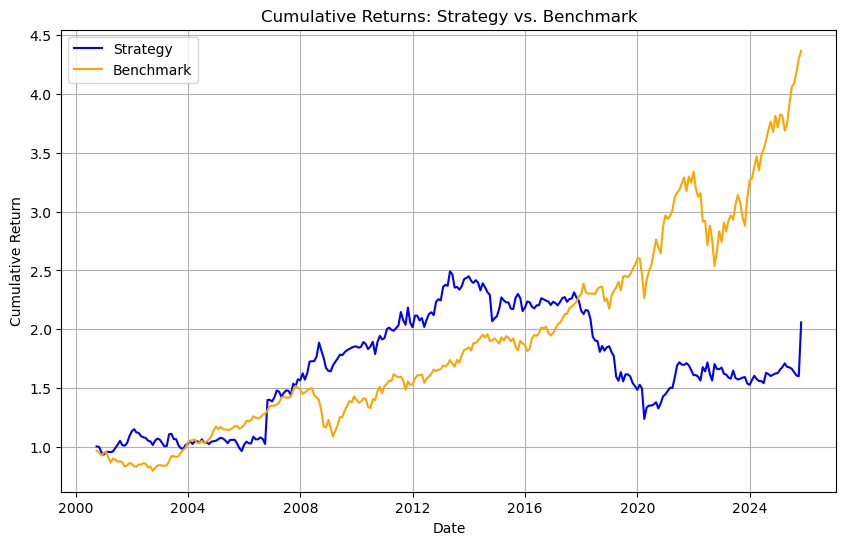

In [69]:
plt.figure(figsize=(10, 6))
plt.plot((1 + results["ret_net"]).cumprod(), label="Strategy", color="blue")
plt.plot((1 + results["ret_bm"]).cumprod(), label="Benchmark", color="orange")
plt.title("Cumulative Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#make the y-axis logarithmic
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()